# Face detection and recognition training pipeline

The following example illustrates how to fine-tune an InceptionResnetV1 model on your own dataset. This will mostly follow standard pytorch training patterns.

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os

#### Define run parameters

The dataset should follow the VGGFace2/ImageNet-style directory layout. Modify `data_dir` to the location of the dataset on wish to finetune on.

In [2]:
data_dir = 'TrainSet'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

#### Determine if an nvidia GPU is available

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

See `help(MTCNN)` for more details.

In [4]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

#### Perfom MTCNN facial detection

Iterate through the DataLoader object and obtain cropped faces.

In [5]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((200, 200)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
        
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)


In [6]:

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn

Batch 4 of 24

/home/jupyter-rushiraj/.local/lib/python3.7/site-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/home/jupyter-rushiraj/.local/lib/python3.7/site-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  boxes = np.array(boxes)
/home/jupyter-rushiraj/.local/lib/python3.7/site-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested seque

Batch 24 of 24

#### Define Inception Resnet V1 module

See `help(InceptionResnetV1)` for more details.

In [6]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

#### Define optimizer, scheduler, dataset, and dataloader

In [7]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

#### Define loss and evaluation functions

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = { 
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

## Train model

In [12]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |     5/5    | loss:    4.0642 | fps:  668.4995 | acc:    0.0149   

Epoch 1/8
----------
Train |    19/19   | loss:    1.7995 | fps:  316.9115 | acc:    0.5864   
Valid |     5/5    | loss:    1.9127 | fps:  674.8303 | acc:    0.4995   

Epoch 2/8
----------
Train |    19/19   | loss:    0.2941 | fps:  313.1545 | acc:    0.9704   
Valid |     5/5    | loss:    0.3552 | fps:  766.5052 | acc:    0.8764   

Epoch 3/8
----------
Train |    19/19   | loss:    0.0792 | fps:  321.0124 | acc:    1.0000   
Valid |     5/5    | loss:    0.1310 | fps:  768.6274 | acc:    0.9812   

Epoch 4/8
----------
Train |    19/19   | loss:    0.0277 | fps:  318.6447 | acc:    1.0000   
Valid |     5/5    | loss:    0.0331 | fps:  806.8425 | acc:    1.0000   

Epoch 5/8
----------
Train |    19/19   | loss:    0.0126 | fps:  319.9738 | acc:    1.0000   
Valid |     5/5    | loss:    0.0313 | fps:  772.9114 | acc:    0.9937   

Epoch 6/8
----------
Train |    19/19   | loss:    0.0

In [13]:
torch.save(resnet.state_dict(), 'GeorgiaTech-TestDataset_StateDict.pth')
torch.save(resnet, "GeorgiaTech-TestDataset.pth")

## Load Model

In [23]:
resnet.load_state_dict(torch.load('GeorgiaTech-TestDataset_StateDict.pth'))

<All keys matched successfully>

# Inference

In [10]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('TestSet')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [11]:
dataset.idx_to_class

{0: 'P1',
 1: 'P10',
 2: 'P11',
 3: 'P12',
 4: 'P13',
 5: 'P14',
 6: 'P15',
 7: 'P16',
 8: 'P17',
 9: 'P18',
 10: 'P19',
 11: 'P2',
 12: 'P20',
 13: 'P21',
 14: 'P22',
 15: 'P23',
 16: 'P24',
 17: 'P25',
 18: 'P26',
 19: 'P27',
 20: 'P28',
 21: 'P29',
 22: 'P3',
 23: 'P30',
 24: 'P31',
 25: 'P32',
 26: 'P33',
 27: 'P34',
 28: 'P35',
 29: 'P36',
 30: 'P37',
 31: 'P38',
 32: 'P39',
 33: 'P4',
 34: 'P40',
 35: 'P41',
 36: 'P42',
 37: 'P43',
 38: 'P44',
 39: 'P45',
 40: 'P46',
 41: 'P47',
 42: 'P48',
 43: 'P49',
 44: 'P5',
 45: 'P50',
 46: 'P6',
 47: 'P7',
 48: 'P8',
 49: 'P9'}

In [12]:
faces, classes = next(iter(loader))


#### Perfom MTCNN facial detection

Iterate through the DataLoader object and detect faces and associated detection probabilities for each. The `MTCNN` forward method returns images cropped to the detected face, if a face was detected. By default only a single detected face is returned - to have `MTCNN` return all detected faces, set `keep_all=True` when creating the MTCNN object above.

To obtain bounding boxes rather than cropped face images, you can instead call the lower-level `mtcnn.detect()` function. See `help(mtcnn.detect)` for details.

In [13]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [20]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999996
Face detected with probability: 0.999527
Face detected with probability: 0.999948
Face detected with probability: 0.999992
Face detected with probability: 0.999991
Face detected with probability: 0.999976
Face detected with probability: 0.999946
Face detected with probability: 0.999998
Face detected with probability: 0.997758
Face detected with probability: 0.999992
Face detected with probability: 0.999997
Face detected with probability: 0.999998
Face detected with probability: 0.999775
Face detected with probability: 0.999863
Face detected with probability: 0.999835
Face detected with probability: 0.999993
Face detected with probability: 0.999999
Face detected with probability: 0.999997
Face detected with probability: 0.999963
Face detected with probability: 1.000000
Face detected with probability: 0.999999
Face detected with probability: 0.999857
Face detected with probability: 0.999982
Face detected with probability: 0.999996
Face detected wi

In [21]:
faces = torch.stack(aligned).to(device)

In [16]:
embeddings = resnet(aligned).detach().cpu()

#### Print distance matrix for classes

In [18]:
import pandas as pd

dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

           P1         P1         P1         P1         P1        P10  \
P1   0.000000   6.564205   7.136287   6.369747   9.244225  27.599197   
P1   6.564205   0.000000   7.967029   7.884267  10.275927  29.083033   
P1   7.136287   7.967029   0.000000   6.441052  11.227943  25.060112   
P1   6.369747   7.884267   6.441052   0.000000  10.508958  27.040245   
P1   9.244225  10.275927  11.227943  10.508958   0.000000  26.470915   
..        ...        ...        ...        ...        ...        ...   
P9  23.077450  21.906578  19.867460  21.923532  22.255459  29.079672   
P9  22.035639  21.274551  18.796385  20.407980  19.802294  26.671961   
P9  19.967724  19.280655  17.176912  19.078711  17.644938  27.060354   
P9  20.227064  20.082287  17.375299  18.839792  18.680183  25.593325   
P9  23.904232  23.085388  20.692949  22.394680  21.556049  26.046614   

          P10        P10        P10        P10  ...         P8         P8  \
P1  28.249353  24.086750  29.459036  26.760435  ...  24.29

## DataLoader based Inference

In [24]:
#faces = faces.to(device)
#faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
prob, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy()
print([dataset.idx_to_class[p] for p in preds])

['P1', 'P1', 'P1', 'P1', 'P1', 'P10', 'P10', 'P10', 'P10', 'P10', 'P11', 'P11', 'P11', 'P11', 'P11', 'P12', 'P12', 'P12', 'P12', 'P12', 'P13', 'P13', 'P13', 'P13', 'P13', 'P14', 'P14', 'P14', 'P14', 'P14', 'P15', 'P15', 'P15', 'P15', 'P15', 'P16', 'P16', 'P16', 'P16', 'P16', 'P17', 'P17', 'P17', 'P17', 'P17', 'P18', 'P18', 'P18', 'P18', 'P18', 'P19', 'P19', 'P19', 'P19', 'P19', 'P2', 'P2', 'P2', 'P2', 'P2', 'P20', 'P20', 'P20', 'P20', 'P20', 'P21', 'P21', 'P21', 'P21', 'P21', 'P22', 'P22', 'P22', 'P22', 'P22', 'P23', 'P23', 'P23', 'P23', 'P23', 'P24', 'P24', 'P24', 'P24', 'P24', 'P25', 'P25', 'P25', 'P25', 'P25', 'P26', 'P26', 'P26', 'P26', 'P26', 'P27', 'P27', 'P27', 'P27', 'P27', 'P28', 'P28', 'P28', 'P28', 'P28', 'P29', 'P29', 'P29', 'P29', 'P29', 'P3', 'P3', 'P3', 'P3', 'P3', 'P30', 'P30', 'P30', 'P30', 'P30', 'P31', 'P31', 'P31', 'P31', 'P31', 'P32', 'P32', 'P32', 'P32', 'P32', 'P33', 'P33', 'P33', 'P33', 'P33', 'P34', 'P34', 'P34', 'P34', 'P34', 'P35', 'P35', 'P35', 'P35', 'P35',

# Single Image Inference

In [36]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

transform = A.Compose([
    ToTensorV2()
])

# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread("TestSet/P1/s01_11.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Augment an image
transformed = transform(image=image)
transformed_image = transformed["image"]

In [26]:
aligned = []
x_aligned, prob = mtcnn(image, return_prob=True)
aligned.append(x_aligned)

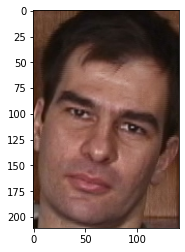

In [28]:
from imports import *
plt.imshow(np.transpose(utils.make_grid(transformed_image.detach().cpu(), padding=2, normalize=False),(1,2,0)))

In [29]:
resnet.eval()              # REQUIRED for Inference or else you will get the BatchNorm 1 channel error

#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
dist, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy() 
print(dist, preds)
print([dataset.idx_to_class[p] for p in preds])

tensor([10.7323], device='cuda:0', grad_fn=<MaxBackward0>) [0]
['P1']


## Wont work if you dont align!

In [37]:
image = transformed_image.unsqueeze(0).float().cuda()
outputs = resnet(image)
dist, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy() 
print(dist, preds)
print([dataset.idx_to_class[p] for p in preds])

tensor([43.6859], device='cuda:0', grad_fn=<MaxBackward0>) [33]
['P4']
